In [244]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#plt.rcParams['figure.figsize'] = (14, 6)

In [245]:
# Useful functions
def to_col(x):   
    if len(x.shape)==1:
        x=x.reshape(x.shape[0],1)
    return x

def to_line(x):
    """ convert an vector to line vector if needed """
    if len(x.shape)==1:
        x=x.reshape(1,x.shape[0])
    return x

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[np.squeeze(labels==l),0],data[np.squeeze(labels==l),1],c=cols[i],marker=marks[i])
        

def make_grid(data=None,xmin=-10,xmax=10,ymin=-10,ymax=10,step=100):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def plot_frontiere(data,f,axe,step=100):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    axe.contour(x,y,f(grid).reshape(x.shape),colors=('blue'),levels=[0])


## Chargement des données

In [246]:
A_train = np.loadtxt('classification_data_HWK1/classificationA.train')
B_train = np.loadtxt('classification_data_HWK1/classificationB.train')
C_train = np.loadtxt('classification_data_HWK1/classificationC.train')
A_test = np.loadtxt('classification_data_HWK1/classificationA.test')
B_test = np.loadtxt('classification_data_HWK1/classificationB.test')
C_test = np.loadtxt('classification_data_HWK1/classificationC.test')

In [247]:
X_A_train.shape

(150, 2)

In [248]:
# Load tous les X_A_train,Y_A_train,X_B_train,Y_B_train ...
for cas in ["A","B","C"]:
    for type_set in ["train","test"]:
        exec("X_"+cas+"_"+type_set+"="+cas+"_"+type_set+"[:,0:2]")
        exec("Y_"+cas+"_"+type_set+"=to_col("+cas+"_"+type_set+"[:,2])")

## 1. MLE Generative model (LDA)

In [249]:
def theta_MLE(Y):
    return(np.sum(Y)/Y.shape[0])

def mu_1_MLE(X,Y):
    return([np.sum(Y*to_col(X[:,0]))/np.sum(Y), np.sum(Y*to_col(X[:,1]))/np.sum(Y)])

def mu_0_MLE(X,Y): 
    return([(np.sum(X[:,0]) - np.sum(Y*to_col(X[:,0])))/(Y.shape[0]-np.sum(Y)), 
            (np.sum(X[:,1]) - np.sum(Y*to_col(X[:,1])))/(Y.shape[0]-np.sum(Y))])

def sigma_MLE(X,Y): 
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    s0 = np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return((s1+s0)/Y.shape[0])

def compute_a(X,Y):
    return(np.dot(np.linalg.inv(sigma_MLE(X,Y)),np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))))

def compute_b(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           -1/2*np.dot(np.dot((np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))),np.linalg.inv(sigma_MLE(X,Y)))
                ,(np.asarray(mu_0_MLE(X,Y))+np.asarray(mu_1_MLE(X,Y)))))


def LDA_prediction(X,a,b):
    return to_col(np.array([np.dot(a,x)+b>=0 for x in X]))

def error(predicted,real_values):
    number_of_missclassified = np.sum(np.abs(predicted-real_values))
    percentage_error = round(number_of_missclassified/float(real_values.shape[0])*100,2)
    return number_of_missclassified,percentage_error

def sigmoid(X):  #fonction sigmoide pour la proba conditionnelle
    return (1/(1+np.exp(-X)))
#def LDA(x,a,b):
#    return(sigmoid(np.dot(a)*x+b))

#### Compute MLE parameters

In [250]:
# definie a_A, a_B, a_c, b_A, ...
for cas in ["A","B","C"]:
    for parameters in ["a","b"]:
        exec(parameters+"_"+cas+"=compute_"+parameters+"(X_"+cas+"_train,Y_"+cas+"_train)")
        
    print("Sample "+cas)
    print("theta_"+cas+"=",eval("theta_MLE(Y_"+cas+"_train)"))
    print("mu_1_"+cas+"=",eval("mu_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("mu_0_"+cas+"=",eval("mu_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_"+cas+"=",eval("sigma_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("a_"+cas+"=", eval("a_"+cas))
    print("b_"+cas+"=", eval("b_"+cas))
    print()
    print()

Sample A
theta_A= 0.333333333333
mu_1_A= [-2.6923200424000004, 0.86604199999999987]
mu_0_A= [2.8997094650999999, -0.89387399999999984]
sigma_A= [[ 2.44190897 -1.13194024]
 [-1.13194024  0.61375465]]
a_A= [-6.62245258 -9.3462503 ]
b_A= -0.136496290948


Sample B
theta_B= 0.5
mu_1_B= [-3.2167073426666666, 1.0830673333333334]
mu_0_B= [3.340688964066667, -0.83546333333333334]
sigma_B= [[ 3.34623467 -0.13516489]
 [-0.13516489  1.73807475]]
a_B= [-1.92108197  0.95442836]
b_B= 0.000929288716542


Sample C
theta_C= 0.625
mu_1_C= [-2.9423288508400001, -0.95782840000000014]
mu_0_C= [2.7930482376000003, -0.8383866666666665]
sigma_C= [[ 2.88039225 -0.63405081]
 [-0.63405081  5.19952435]]
a_C= [-2.05129911 -0.27311529]
b_C= 0.112429132177




#### Apply to data

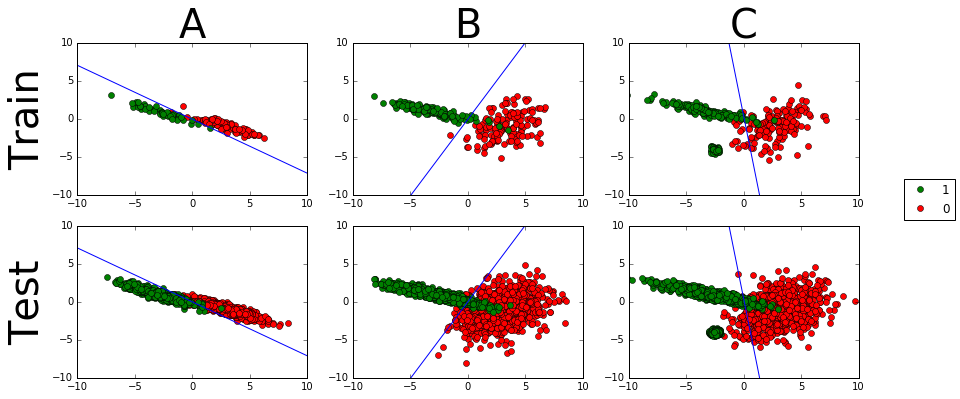

In [251]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        # Affichage des données
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")
        
    # Affichage de la ligne de p(Y=1|X)
    a = eval("a_"+cas)
    b = eval("b_"+cas)
    x1 = np.linspace(-10,10)
    x2= (-a[0]*x1-b)/a[1]
    axes[0][Cases.index(cas)].plot(x1,x2,'b')
    axes[1][Cases.index(cas)].plot(x1,x2,'b')
fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()

In [252]:
#calcul de l'erreur
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        a = eval("a_"+cas)
        b = eval("b_"+cas)
        x = eval("X_"+cas+"_"+s)
        predicted = LDA_prediction(x,a,b)
        real_values = eval("Y_"+cas+"_"+s)
        number_of_missclassified,percentage_error = error(predicted,real_values)
        print(cas+" "+s+" : "+str(int(number_of_missclassified))+" points mal classifiés soit "+str(percentage_error)+" % d'erreur")
    print     

A train : 2 points mal classifiés soit 1.33 % d'erreur
A test : 30 points mal classifiés soit 2.0 % d'erreur
B train : 9 points mal classifiés soit 3.0 % d'erreur
B test : 83 points mal classifiés soit 4.15 % d'erreur
C train : 22 points mal classifiés soit 5.5 % d'erreur
C test : 127 points mal classifiés soit 4.23 % d'erreur


In [253]:
### JE ME SUIS ARRETE LA

## 2. Regression logistique

## 3. Regression lineaire

## 5. QDA model

In [255]:
def sigma_0_MLE(X,Y):
    s0 =np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return(s0/(Y.shape[0]-np.sum(Y)))

def sigma_1_MLE(X,Y):
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    return(s1/np.sum(Y))

def compute_c(X,Y):
    return(np.dot(np.linalg.inv(sigma_1_MLE(X,Y)),np.asarray(mu_1_MLE(X,Y)))
           -np.dot(np.linalg.inv(sigma_0_MLE(X,Y)),np.asarray(mu_0_MLE(X,Y))))


def compute_d(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           + 1/2*np.log(np.linalg.det(sigma_0_MLE(X,Y))/np.linalg.det(sigma_1_MLE(X,Y)))
           + 1/2*np.dot(np.dot(np.asarray(mu_0_MLE(X,Y)),np.linalg.inv(sigma_0_MLE(X,Y))),np.asarray(mu_0_MLE(X,Y)))
           - 1/2*np.dot(np.dot(np.asarray(mu_1_MLE(X,Y)),np.linalg.inv(sigma_1_MLE(X,Y))),np.asarray(mu_1_MLE(X,Y))))
    
def compute_M(X,Y):
    return(np.linalg.inv(sigma_0_MLE(X,Y))-np.linalg.inv(sigma_1_MLE(X,Y)))


#A VERIFIER
def QDA_eval_quad_vect(X,c,d,M):
    return np.array([np.array(1/2*np.dot(np.dot(x,M),x)+np.dot(c,x)+d) for x in X])



def QDA_eval_quad(x,c,d,M):
    return np.array(1/2*np.dot(np.dot(x,M),x)+np.dot(c,x)+d)

def QDA_prediction(X,c,d,M):
    return to_col(np.array([QDA_eval_quad(x,c,d,M)>=0 for x in X]))



#### Compute MLE parameters

In [256]:
# definie a_A, a_B, a_c, b_A, ...
for cas in ["A","B","C"]:
    for parameters in ["c","d","M"]:
        exec(parameters+"_"+cas+"=compute_"+parameters+"(X_"+cas+"_train,Y_"+cas+"_train)")
        
    print("Sample "+cas)
    print("theta_"+cas+"=",eval("theta_MLE(Y_"+cas+"_train)"))
    print("mu_1_"+cas+"=",eval("mu_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("mu_0_"+cas+"=",eval("mu_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_0"+cas+"=",eval("sigma_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_1"+cas+"=",eval("sigma_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("c_"+cas+"=", eval("c_"+cas))
    print("d_"+cas+"=", eval("d_"+cas))
    print("M_"+cas+"=", eval("M_"+cas))
    print()
    print()

Sample A
theta_A= 0.333333333333
mu_1_A= [-2.6923200424000004, 0.86604199999999987]
mu_0_A= [2.8997094650999999, -0.89387399999999984]
sigma_0A= [[ 2.31065259 -1.04748461]
 [-1.04748461  0.57578403]]
sigma_1A= [[ 2.70442172 -1.3008515 ]
 [-1.3008515   0.68969588]]
c_A= [ -7.36527314 -10.87335416]
d_A= -0.626271453018
M_A= [[-1.51744039 -3.0272297 ]
 [-3.0272297  -5.72332675]]


Sample B
theta_B= 0.5
mu_1_B= [-3.2167073426666666, 1.0830673333333334]
mu_0_B= [3.340688964066667, -0.83546333333333334]
sigma_0B= [[ 2.53885859  1.0642112 ]
 [ 1.0642112   2.96007891]]
sigma_1B= [[ 4.15361075 -1.33454097]
 [-1.33454097  0.51607059]]
c_B= [-2.28065009  1.45700199]
d_B= 3.366501856
M_B= [[ -0.95965255  -3.84765056]
 [ -3.84765056 -11.05867014]]


Sample C
theta_C= 0.625
mu_1_C= [-2.9423288508400001, -0.95782840000000014]
mu_0_C= [2.7930482376000003, -0.8383866666666665]
sigma_0C= [[ 2.89913927  1.24581553]
 [ 1.24581553  2.92475448]]
sigma_1C= [[ 2.86914403 -1.76197061]
 [-1.76197061  6.56438626

#### Apply to data

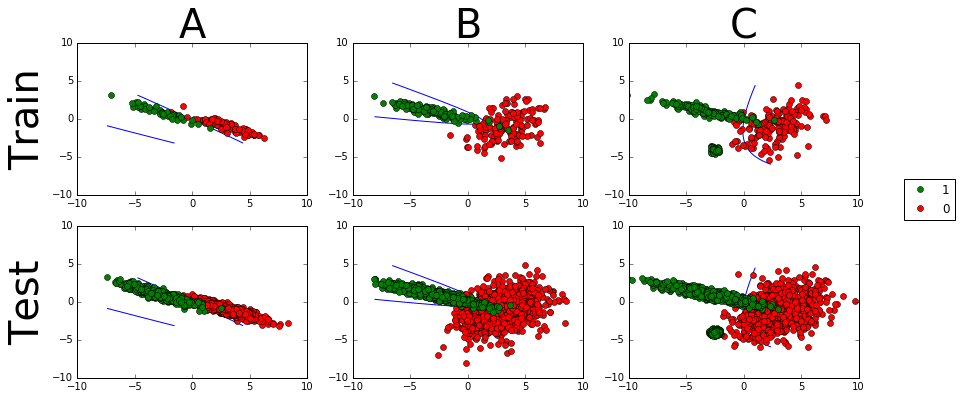

In [257]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        # Affichage des données
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")
        
        # Affichage de la ligne de p(Y=1|X)
    c = eval("c_"+cas)
    d = eval("d_"+cas)
    M = eval("M_"+cas)
    
    plot_frontiere(eval("X_"+cas+"_"+s),lambda x:QDA_eval_quad_vect(x,c,d,M),axes[0][Cases.index(cas)],100)
    plot_frontiere(eval("X_"+cas+"_"+s),lambda x:QDA_eval_quad_vect(x,c,d,M),axes[1][Cases.index(cas)],100)
#    axes[Sets.index(s)][Cases.index(cas)].plot_frontiere(X_A_test_A[:,0:2],front_QDA,100)
fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()

In [ ]:
print(np.shape(X_A_train))
plot_data(X_A_test,Y_A_test)

In [122]:
#LDA(X_A_train, Y_A_train)

In [ ]:
Theta_MLE_A = (1.0/np.shape(A_train)[0])*sum([a[2] for a in A_train])
Theta_MLE_B = (1.0/np.shape(B_train)[0])*sum([b[2] for b in B_train])
Theta_MLE_C = (1.0/np.shape(C_train)[0])*sum([c[2] for c in C_train])

print Theta_MLE_A
print Theta_MLE_B
print Theta_MLE_C

mu_0_MLE_A = np.sum([(1-a[2])*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([(1-a[2]) for a in A_train])
mu_0_MLE_B = np.sum([(1-b[2])*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([(1-b[2]) for b in B_train])
mu_0_MLE_C = np.sum([(1-c[2])*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([(1-c[2]) for c in C_train])

print mu_0_MLE_A
print mu_0_MLE_B
print mu_0_MLE_C

mu_1_MLE_A = np.sum([a[2]*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([a[2] for a in A_train])
mu_1_MLE_B = np.sum([b[2]*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([b[2] for b in B_train])
mu_1_MLE_C = np.sum([c[2]*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([c[2] for c in C_train])

print mu_1_MLE_A
print mu_1_MLE_B
print mu_1_MLE_C

def p_Y1_X(x,theta,mu_0,mu_1,sigma):#x vecteur vertical
    return( 1.0/(1.0+((1.0-theta)/(theta))*exp((((mu_0+mu_1)[np.newaxis]).T).dot(sigma).dot(x) - (1.0/2)*((mu_0.T).dot(sigma).dot(mu_0) + (mu_1.T).dot(sigma).dot(mu_1))))
    

In [ ]:
print A_train[:3]

In [ ]:
print [np.array([a[0],a[1]]) for a in A_train][:2]

In [ ]:
a = np.array([1,2])
b = np.array([[3,4],[5,6]])
print np.transpose(a[np.newaxis])*b

In [ ]:
#transformer un vecteur ligne en colone
vecteur_ligne = np.array([1,2,3])
vecteur_colone = np.transpose(vecteur_ligne[np.newaxis])
print vecteur_ligne
print np.transpose(vecteur_colone).dot(np.array([[1,2,0],[0,1,0],[0,0,1]])).dot(vecteur_colone)

print vecteur_colone.T